# Предсказывание в ритейл
## Подготовка данных

In [ ]:
!pip install catboost
!pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Загрузим данные:

In [2]:
data_train = pd.read_csv('train.csv')
data_train

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,id
0,2019-12-30,425.0,22939.0,NaN,0.0,0.0,3649.0,2736.75,0.0,0.0,1
1,2019-12-30,525.0,22939.0,NaN,0.0,0.0,3649.0,2371.85,0.0,1.0,3
2,2019-12-30,557.0,22939.0,NaN,0.0,0.0,3649.0,2736.75,0.0,1.0,5
3,2019-12-30,562.0,22939.0,NaN,0.0,0.0,3649.0,2736.75,0.0,0.0,7
4,2019-12-30,637.0,22939.0,NaN,0.0,0.0,3649.0,3101.65,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...
2333098,2019-12-30,NaN,NaN,NaN,1.0,0.0,3949.0,2369.40,0.0,1.0,2337654
2333099,2019-12-30,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,0.0,2337655
2333100,2019-12-30,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,0.0,2337656
2333101,2019-12-30,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,0.0,2337657


In [3]:
data_test = pd.read_csv('test.csv')
data_test

,product_id,location_id,period_dt,id
0,22939,1162,2019-12-30,16
1,23162,1162,2019-12-30,7867
2,23163,1162,2019-12-16,8667
3,23632,798,2019-12-23,14835
4,23633,1347,2019-12-30,14959
...,...,...,...,...
588,139157,1326,2019-12-16,203996
589,139157,1347,2019-12-09,203997
590,148040,425,2019-12-09,204035
591,148040,525,2019-12-09,204037


Подготовим данные

In [4]:
data_train.dtypes

period_dt             object
location_id          float64
product_id           float64
demand               float64
PROMO1_FLAG          float64
PROMO2_FLAG          float64
PRICE_REGULAR        float64
PRICE_AFTER_DISC     float64
NUM_CONSULTANT       float64
AUTORIZATION_FLAG    float64
id                     int64
dtype: object

In [5]:
data_test.dtypes

product_id      int64
location_id     int64
period_dt      object
id              int64
dtype: object

Видно, что необходимо конвертировать столбец period_dt к типу DATE. Сделаем специальную функцию для этого:

In [6]:
def convert_date_type(df):
    data = pd.to_datetime(df['period_dt'])
    df.drop(columns=['period_dt'], inplace=True)
    df['day'] = data.dt.day
    df['month'] = data.dt.month
    df['year'] = data.dt.year
    df['week_of_year'] = data.dt.weekofyear
    df['day_of_year'] = data.dt.dayofyear

In [7]:
convert_date_type(data_train)
convert_date_type(data_test)

In [8]:
data_train.dtypes

location_id          float64
product_id           float64
demand               float64
PROMO1_FLAG          float64
PROMO2_FLAG          float64
PRICE_REGULAR        float64
PRICE_AFTER_DISC     float64
NUM_CONSULTANT       float64
AUTORIZATION_FLAG    float64
id                     int64
day                    int64
month                  int64
year                   int64
week_of_year           int64
day_of_year            int64
dtype: object

Посмотрим, есть ли пропуски в данных:

In [9]:
data_train.isna().sum()

location_id          2048984
product_id           2048984
demand               2058632
PROMO1_FLAG             1797
PROMO2_FLAG             1797
PRICE_REGULAR         810628
PRICE_AFTER_DISC      831151
NUM_CONSULTANT          1797
AUTORIZATION_FLAG       1797
id                         0
day                        0
month                      0
year                       0
week_of_year               0
day_of_year                0
dtype: int64

In [10]:
def fill_bools(X):
    Y = X.copy()
    vals = {"PROMO1_FLAG": 0, "PROMO2_FLAG": 0, "NUM_CONSULTANT": 0, "AUTORIZATION_FLAG": 0} 
    return Y.fillna(value=vals)

def fill_floats(store_ids, X):
    Y = X.copy()
    for store in store_ids:
        val1 = Y.loc[Y["product_id"] == store]["PRICE_REGULAR"].mean()
        val2 = Y.loc[Y["product_id"] == store]["PRICE_AFTER_DISC"].mean()
        val3 = Y.loc[Y["product_id"] == store]["demand"].mean()
        Y.loc[(Y["product_id"] == store) & (Y["PRICE_REGULAR"].isna()), "PRICE_REGULAR"] = val1
        Y.loc[(Y["product_id"] == store) & (Y["PRICE_AFTER_DISC"].isna()), "PRICE_AFTER_DISC"] = val2
        Y.loc[(Y["product_id"] == store) & (Y["demand"].isna()), "demand"] = val3
    return Y

PROMO1_FLAG, PROMO2_FLAG заполним нулями, используя логику, как на семинарах, если акция не указана, скорее всего ее не было. Так же поступим с NUM_CONSULTANT. AUTORIZATION_FLAG тоже заполним 0, преполагая, что авторицазии не было. PRICE_REGULAR и PRICE_AFTER_DISC заполним средними значениями по столбцам:

In [11]:
dtypes_train = {"PROMO1_FLAG": np.int32, "PROMO2_FLAG": np.int32,
                                            "NUM_CONSULTANT": np.int32, "AUTORIZATION_FLAG": np.int32,
                                            "demand": np.float32, "PRICE_REGULAR": np.float32, "PRICE_AFTER_DISC": np.float32,
                                            "day": np.int32, "month": np.int32, "year": np.int32,
                                            "week_of_year": np.int32, "day_of_year": np.int32}
dtypes_test = {"day": np.int32, "month": np.int32, "year": np.int32,
                "week_of_year": np.int32, "day_of_year": np.int32,
                "location_id": np.int32, "product_id": np.int32}
dtypes_aposterior = {"location_id": np.int32, "product_id": np.int32}
data_train_clear = fill_floats(data_train.groupby("product_id").mean().index, data_train)
data_train_clear = fill_bools(data_train_clear)
data_train_clear = data_train_clear.astype(dtypes_train)
data_test_clear = data_test.astype(dtypes_test)
data_train_clear = data_train_clear.dropna()
data_train_clear = data_train_clear.astype(dtypes_aposterior)
data_train_clear = data_train_clear.drop(columns=["id"])
data_test_clear = data_test_clear.drop(columns=["id"])

In [12]:
data_train_clear.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,day,month,year,week_of_year,day_of_year
0,425,22939,0.170391,0,0,3649.0,2736.750000,0,0,30,12,2019,1,364
1,525,22939,0.170391,0,0,3649.0,2371.850098,0,1,30,12,2019,1,364
2,557,22939,0.170391,0,0,3649.0,2736.750000,0,1,30,12,2019,1,364
3,562,22939,0.170391,0,0,3649.0,2736.750000,0,0,30,12,2019,1,364
4,637,22939,0.170391,0,0,3649.0,3101.649902,0,0,30,12,2019,1,364


## Выбор признаков

In [13]:
#features = lagged_features(data_train, data_train['demand'], data_train['location_id'])
data_train_features = data_train_clear.copy()
data_test_features = data_test_clear.copy()

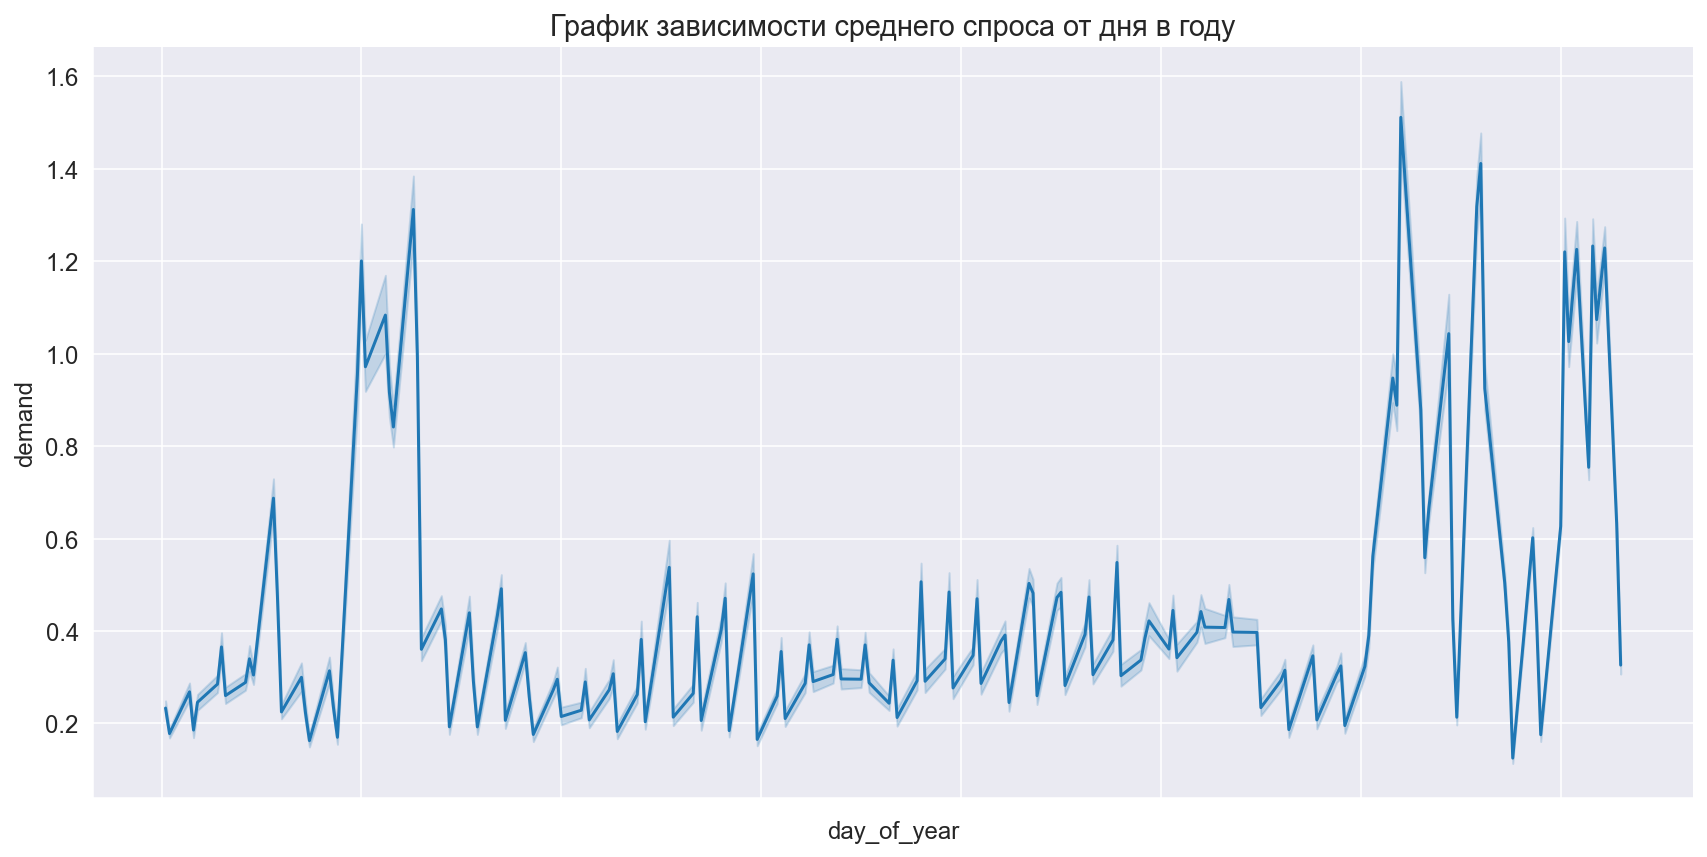

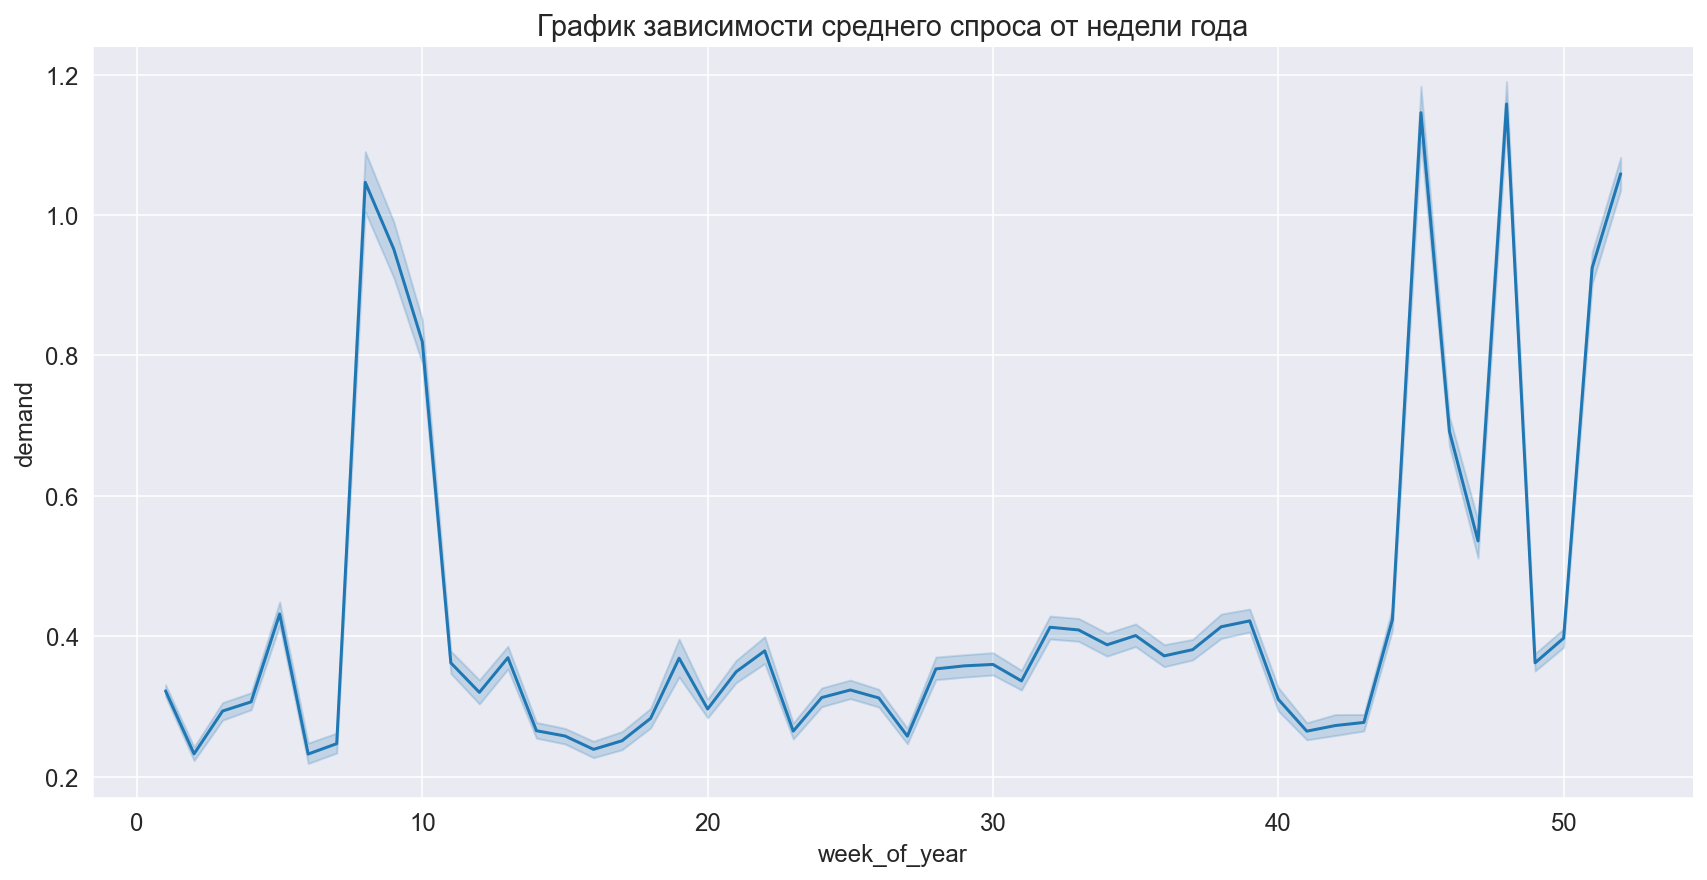

In [14]:
plot = sns.relplot(data=data_train_clear, x="day_of_year", y="demand", kind="line", palette="hls", height=6, aspect=2)
plot.set(xticklabels=[], title="График зависимости среднего спроса от дня в году")
plt.show()
plot = sns.relplot(data=data_train_clear, x="week_of_year", y="demand", kind="line", palette="hls", height=6, aspect=2)
plot.set(title="График зависимости среднего спроса от недели года")
plt.show()

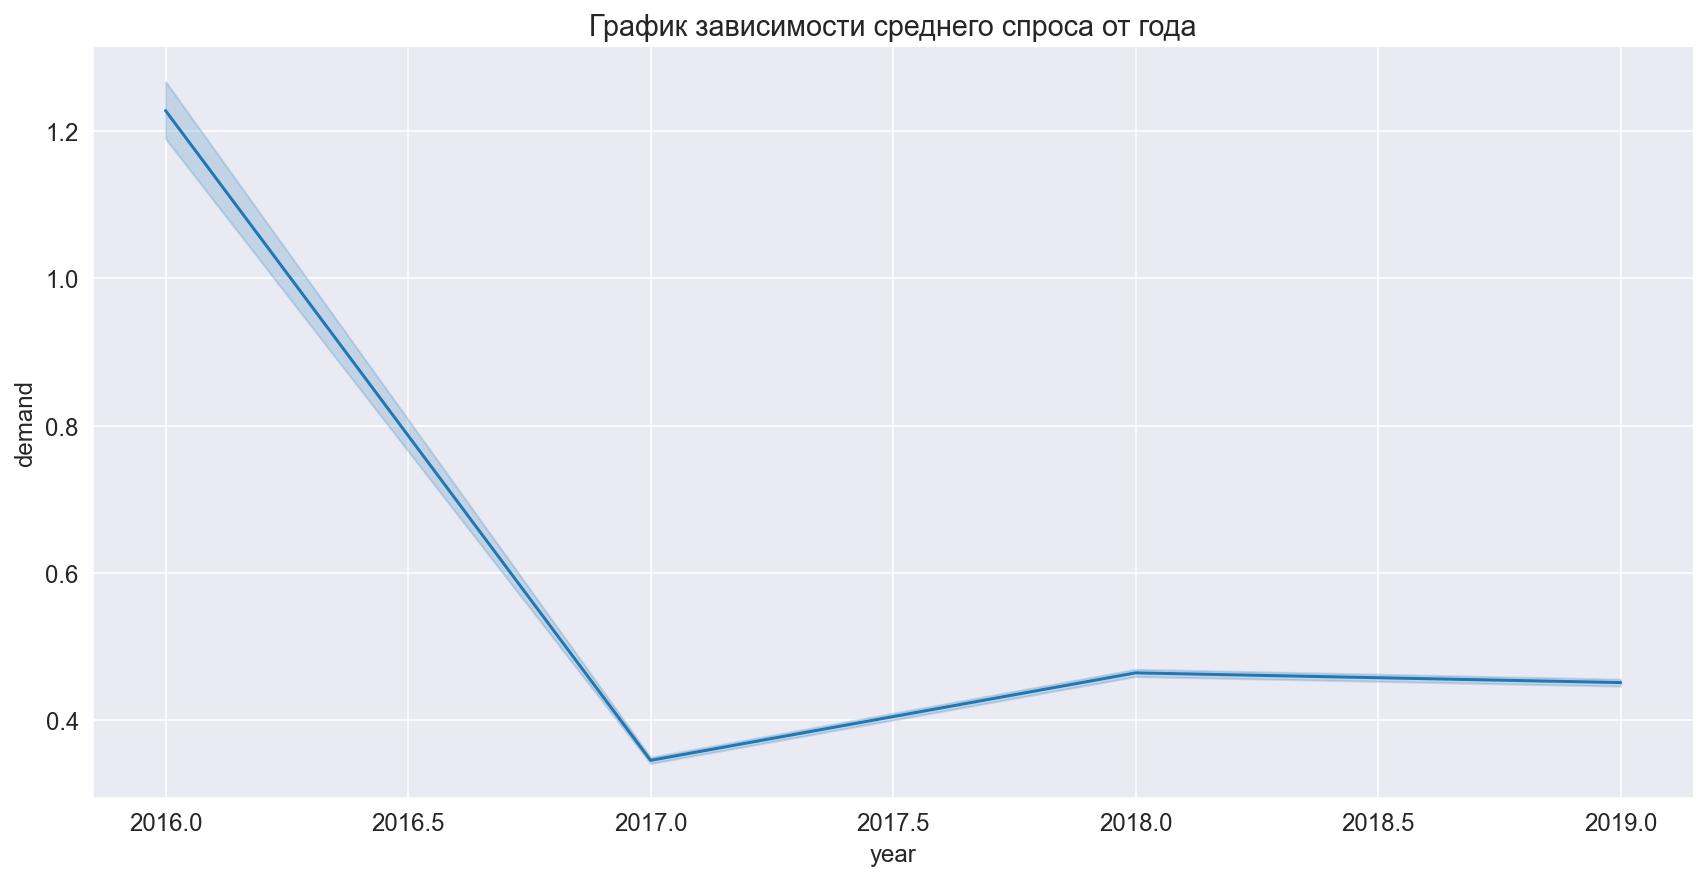

In [15]:
plot = sns.relplot(data=data_train_clear, x="year", y="demand", kind="line", palette="hls", height=6, aspect=2)
plot.set(title="График зависимости среднего спроса от года")
plt.show()

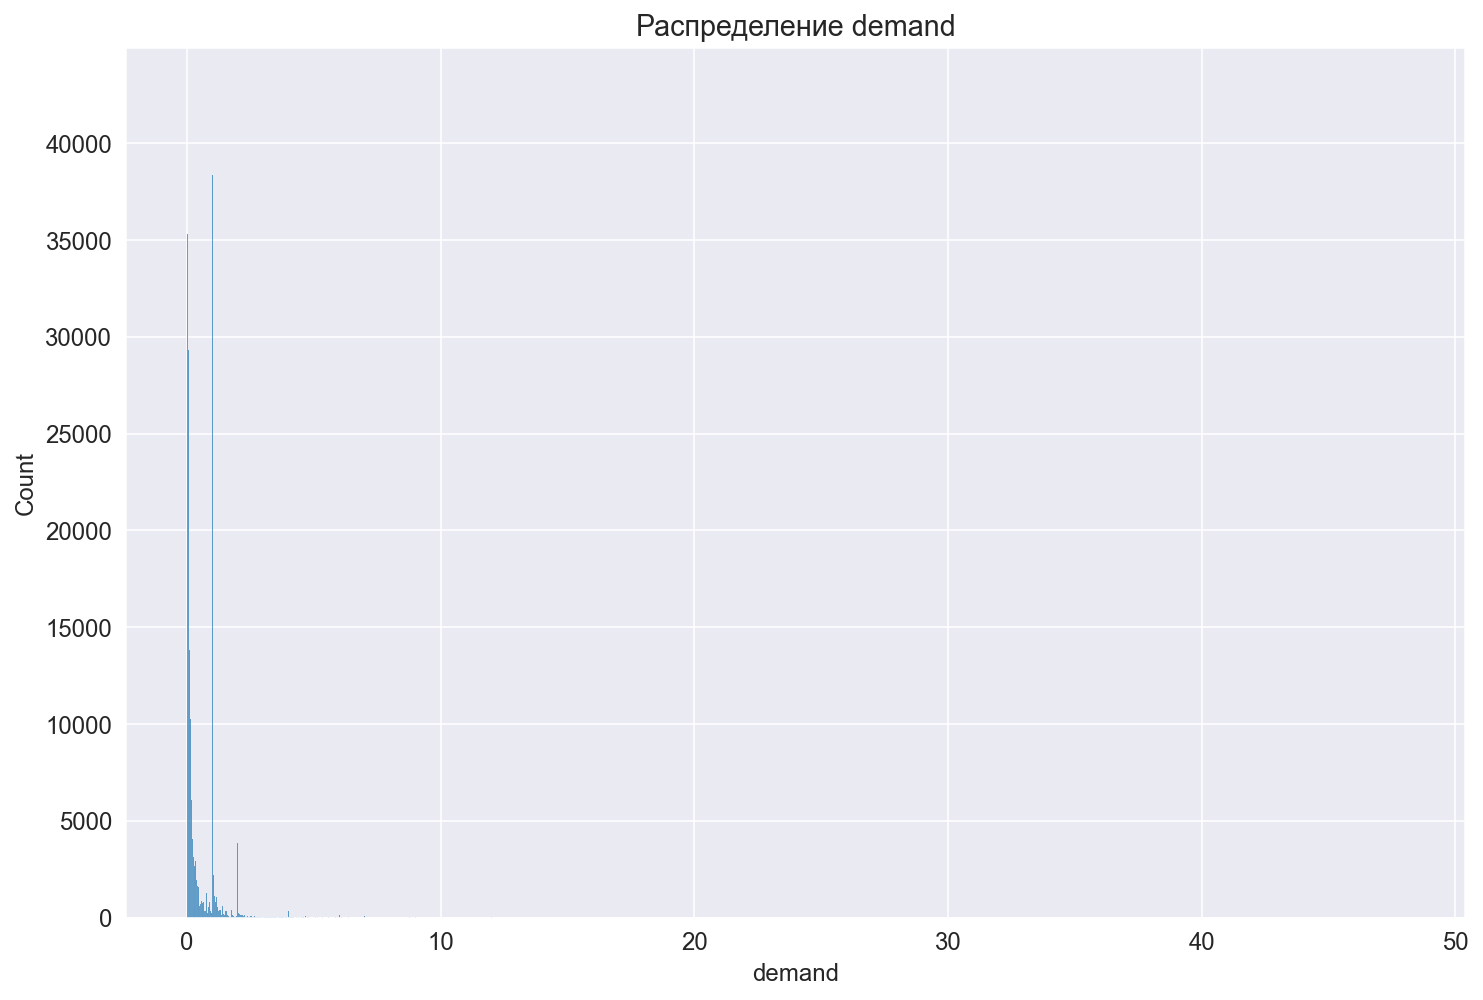

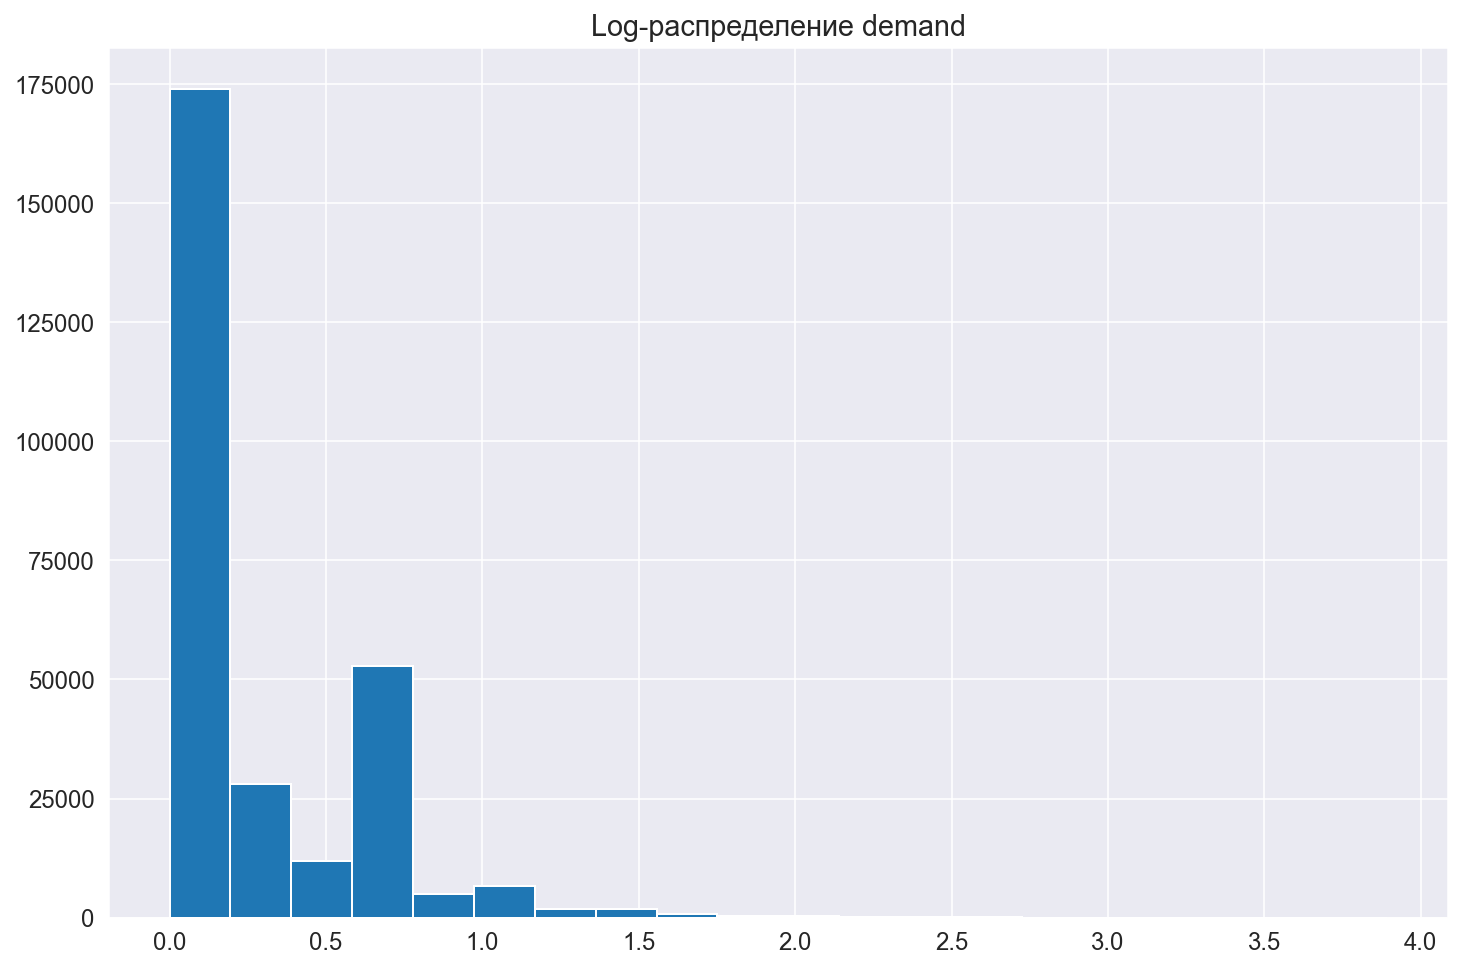

In [16]:
plot = sns.histplot(data=data_train_clear, x="demand")
plot.set(title="Распределение demand")
plt.show()
plt.hist(np.log1p(data_train_clear["demand"]), bins=20)
plt.title("Log-распределение demand")
plt.show()

In [17]:
def add_high_demand(X, tres=0.6):
    Y = X.copy()
    ids = data_train_clear.groupby("week_of_year").mean()[(data_train_clear.groupby("week_of_year").mean()["demand"] > tres)].index.values
    Y["high_demand_week"] = 0
    Y["high_demand_year"] = 0
    Y.loc[Y["week_of_year"].isin(ids), "high_demand_week"] = 1
    Y.loc[Y["year"] < 2017, "high_demand_year"] = 1
    return Y

data_train_features = add_high_demand(data_train_features)
data_test_features = add_high_demand(data_test_features)
data_train_features["log_demand"] = np.log1p(data_train_clear["demand"])

In [18]:
data_train_features.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,day,month,year,week_of_year,day_of_year,high_demand_week,high_demand_year,log_demand
0,425,22939,0.170391,0,0,3649.0,2736.750000,0,0,30,12,2019,1,364,0,0,0.157338
1,525,22939,0.170391,0,0,3649.0,2371.850098,0,1,30,12,2019,1,364,0,0,0.157338
2,557,22939,0.170391,0,0,3649.0,2736.750000,0,1,30,12,2019,1,364,0,0,0.157338
3,562,22939,0.170391,0,0,3649.0,2736.750000,0,0,30,12,2019,1,364,0,0,0.157338
4,637,22939,0.170391,0,0,3649.0,3101.649902,0,0,30,12,2019,1,364,0,0,0.157338


## Обучение модели

In [19]:
y = data_train_features['log_demand']
X = data_train_features.drop(columns=["demand"])[['location_id', 'product_id', 'day_of_year', "high_demand_week", "high_demand_year"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=322)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=322)
Test = data_test_features[['location_id', 'product_id', 'day_of_year', "high_demand_week", "high_demand_year"]]

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categor = []
numer = ["location_id", "product_id", "day_of_year"]

col_transformer = ColumnTransformer([
    ("standart", StandardScaler(), numer),
    ("ohe", OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore"), categor)
], remainder="passthrough", n_jobs=-1)
col_transformer.fit(X_train)

X_train = col_transformer.transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)
Test = col_transformer.transform(Test)

In [21]:
import optuna

def objective(trial):
    param = {
        "logging_level": "Silent",
        "random_state": 322,
        "eval_metric": "MAE",
        "n_estimators": trial.suggest_int("n_estimators", 5, 25),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
        "bootstrap_type": "Bernoulli",
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "depth": trial.suggest_int("depth", 1, 15)
      }
    booster = CatBoostRegressor(**param).fit(X_train, y_train, eval_set=(X_val, y_val))
    y_pred = booster.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
# {'n_estimators': 20, 'learning_rate': 0.8216148051350802, 'subsample': 0.9574480991797255, 'depth': 12}

[I 2022-06-16 17:27:48,629] A new study created in memory with name: no-name-5ffe30a8-75f4-4e23-8ffd-9e9340589728
[I 2022-06-16 17:27:48,948] Trial 0 finished with value: 0.2206388784345843 and parameters: {'n_estimators': 5, 'learning_rate': 0.30729070464548075, 'subsample': 0.31548751434947836, 'depth': 11}. Best is trial 0 with value: 0.2206388784345843.
[I 2022-06-16 17:27:49,070] Trial 1 finished with value: 0.2105428477335141 and parameters: {'n_estimators': 7, 'learning_rate': 0.5419270535696827, 'subsample': 0.3841398826080772, 'depth': 8}. Best is trial 1 with value: 0.2105428477335141.
[I 2022-06-16 17:27:51,056] Trial 2 finished with value: 0.1992026554131499 and parameters: {'n_estimators': 18, 'learning_rate': 0.3539001240438641, 'subsample': 0.8318800883982177, 'depth': 14}. Best is trial 2 with value: 0.1992026554131499.
[I 2022-06-16 17:27:51,684] Trial 3 finished with value: 0.2103588819420978 and parameters: {'n_estimators': 22, 'learning_rate': 0.15095553642337975, '

In [23]:
best_params = {'n_estimators': 24, 'learning_rate': 0.9147807920942731, 'subsample': 0.6177767377879807, 'depth': 15}
# best_params = {'n_estimators': 20, 'learning_rate': 0.8216148051350802, 'subsample': 0.9574480991797255, 'depth': 12}
booster = CatBoostRegressor(random_seed=322, logging_level="Silent", **best_params, eval_metric="MAE", bootstrap_type="Bernoulli")\
              .fit(X_train, y_train)

y_pred = booster.predict(X_test)

In [24]:
mean_absolute_error(y_test, y_pred)

0.1898641534751304

## Предсказываем

In [25]:
data_test_features["demand"] = booster.predict(Test)
data_test_features["demand"] = np.expm1(data_test_features["demand"])

In [26]:
data_test_features.head()

,product_id,location_id,day,month,year,week_of_year,day_of_year,high_demand_week,high_demand_year,demand
0,22939,1162,30,12,2019,1,364,0,0,0.182245
1,23162,1162,30,12,2019,1,364,0,0,0.218312
2,23163,1162,16,12,2019,51,350,1,0,0.176656
3,23632,798,23,12,2019,52,357,1,0,0.364685
4,23633,1347,30,12,2019,1,364,0,0,0.329716


In [27]:
submission = pd.DataFrame(data={'id': data_test["id"], 'demand': data_test_features["demand"]})
submission.head()

,id,demand
0,16,0.182245
1,7867,0.218312
2,8667,0.176656
3,14835,0.364685
4,14959,0.329716


In [28]:
submission.to_csv('submission.csv', index=False)